In [1]:
#!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv("Predict Hair Fall.csv")

In [47]:
df.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [48]:
print(df.shape)

(999, 13)


In [49]:
df.nunique()

Id                           995
Genetics                       2
Hormonal Changes               2
Medical Conditions            11
Medications & Treatments      11
Nutritional Deficiencies      11
Stress                         3
Age                           33
Poor Hair Care Habits          2
Environmental Factors          2
Smoking                        2
Weight Loss                    2
Hair Loss                      2
dtype: int64

In [50]:
df.isnull().sum()

Id                           0
Genetics                     0
Hormonal Changes             0
Medical Conditions           0
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64

In [51]:
df.duplicated().sum()

0

In [52]:
df.dtypes

Id                            int64
Genetics                     object
Hormonal Changes             object
Medical Conditions           object
Medications & Treatments     object
Nutritional Deficiencies     object
Stress                       object
Age                           int64
Poor Hair Care Habits        object
Environmental Factors        object
Smoking                      object
Weight Loss                  object
Hair Loss                     int64
dtype: object

In [53]:
numerical_columns=df.select_dtypes(include=['int64']).columns
categorical_columns=df.select_dtypes(include=['object']).columns

In [54]:
numerical_columns

Index(['Id', 'Age', 'Hair Loss'], dtype='object')

In [55]:
categorical_columns

Index(['Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss '],
      dtype='object')

In [56]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['Id', 'Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Age', 'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss ', 'Hair Loss'],
      dtype='object')


In [57]:
df.describe()

,Id,Age,Hair Loss
count,999.000000,999.000000,999.000000
mean,153354.673674,34.188188,0.497497
std,25516.041985,9.377980,0.500244
min,110003.000000,18.000000,0.000000
25%,131867.500000,26.000000,0.000000
50%,152951.000000,34.000000,0.000000
75%,174969.000000,42.000000,1.000000
max,199949.000000,50.000000,1.000000


In [58]:
# Function to identify outliers in numerical columns
def identify_numerical_outliers(df, numerical_columns, contamination=0.05, random_state=42):
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    outliers = iso_forest.fit_predict(df[numerical_columns])
    
    # Mark numerical outliers as True where outliers == -1
    df['numerical_outlier'] = (outliers == -1)
    
    return df

# Function to identify outliers in categorical columns based on frequency threshold
def identify_categorical_outliers(df, categorical_columns, threshold=0.01):
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in categorical_columns:
        freq = df[col].value_counts(normalize=True)
        rare_values = freq[freq < threshold].index
        
        # Mark categorical outliers as True if the value is in the rare list
        outlier_flags[f'{col}_outlier'] = df[col].isin(rare_values)
    
    # Combine all categorical outliers into a single column
    df['categorical_outlier'] = outlier_flags.any(axis=1)
    
    return df


# Identify numerical and categorical columns in the dataset
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical outliers
df = identify_numerical_outliers(df, numerical_columns)

# Identify categorical outliers (e.g., less than 1% frequency)
df = identify_categorical_outliers(df, categorical_columns, threshold=0.01)

# Print results
numerical_outlier_percentage = (df['numerical_outlier'].sum() / len(df)) * 100
categorical_outlier_percentage = (df['categorical_outlier'].sum() / len(df)) * 100

print(f"Percentage of numerical outliers: {numerical_outlier_percentage:.2f}%")
print(f"Percentage of categorical outliers: {categorical_outlier_percentage:.2f}%")


Percentage of numerical outliers: 5.01%
Percentage of categorical outliers: 0.20%


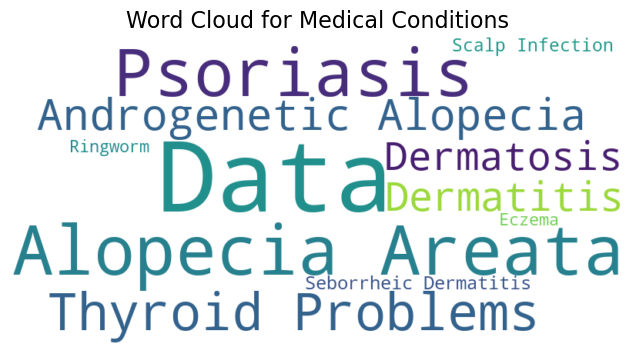

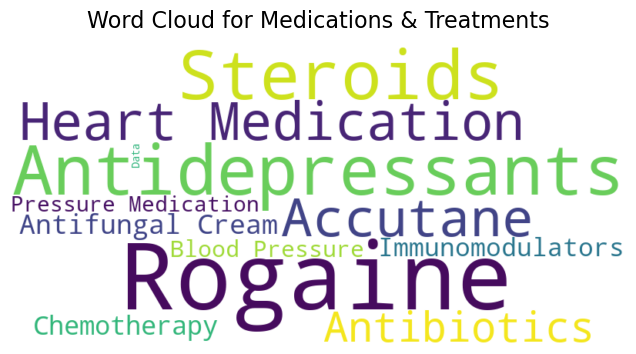

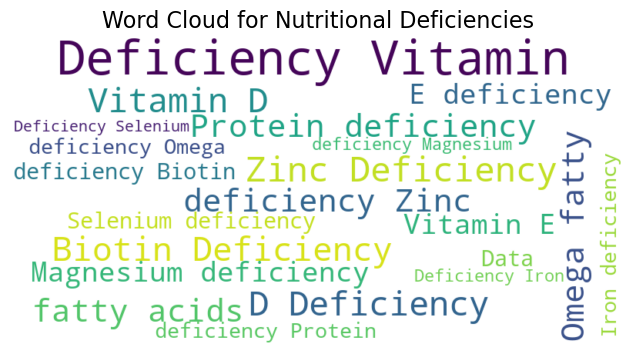

In [59]:
def generate_wordcloud(column_data, title):
    text_data = ' '.join(column_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes for better visualization
    plt.title(title, fontsize=16)
    plt.show()

# Generate word clouds for each of the three variables
generate_wordcloud(df['Medical Conditions'], 'Word Cloud for Medical Conditions')
generate_wordcloud(df['Medications & Treatments'], 'Word Cloud for Medications & Treatments')
generate_wordcloud(df['Nutritional Deficiencies'], 'Word Cloud for Nutritional Deficiencies')


### Basic Data Preprocessing

In [60]:
X = df.drop(['Hair Loss'], axis =1 )
y = df['Hair Loss']

categorical_cols = X.select_dtypes('O').columns.tolist()
numerical_cols = X.select_dtypes(exclude = 'O').columns.tolist()

In [61]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", oh_transformer, categorical_cols),
        ("StandardScaler", numeric_transformer, numerical_cols),
    ]
)

In [62]:
X_scaled = preprocessor.fit_transform(X)
X_scaled

<999x52 sparse matrix of type '<class 'numpy.float64'>'
	with 13986 stored elements in Compressed Sparse Row format>

**NOTE:** Based on the domain (healthcare), the dataset's outliers and extreme Numerical feature values are equally important to normal data for Hair Loss Classification. That's why, the outliers are not eliminated and the data are kept consistent with the original dataset.


## EDA

In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [64]:
# 1. Data Overview
print(df.info())  # Data types and non-null counts
print(df.describe())  # Descriptive statistics for continuous variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Id                        999 non-null    int64 
 1   Genetics                  999 non-null    object
 2   Hormonal Changes          999 non-null    object
 3   Medical Conditions        999 non-null    object
 4   Medications & Treatments  999 non-null    object
 5   Nutritional Deficiencies  999 non-null    object
 6   Stress                    999 non-null    object
 7   Age                       999 non-null    int64 
 8   Poor Hair Care Habits     999 non-null    object
 9   Environmental Factors     999 non-null    object
 10  Smoking                   999 non-null    object
 11  Weight Loss               999 non-null    object
 12  Hair Loss                 999 non-null    int64 
 13  numerical_outlier         999 non-null    bool  
 14  categorical_outlier       

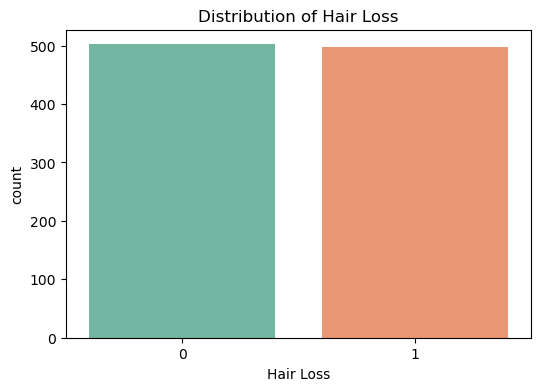

In [65]:
# 2. Target Variable (Hair Loss) Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Hair Loss', data=df, palette='Set2')
plt.title('Distribution of Hair Loss')
plt.show()

Value counts for Genetics:
 Genetics
Yes    522
No     477
Name: count, dtype: int64


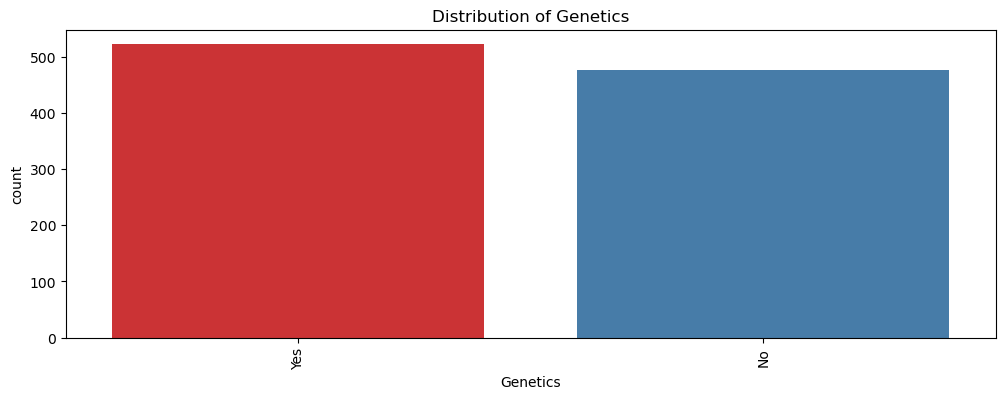

Value counts for Hormonal Changes:
 Hormonal Changes
Yes    509
No     490
Name: count, dtype: int64


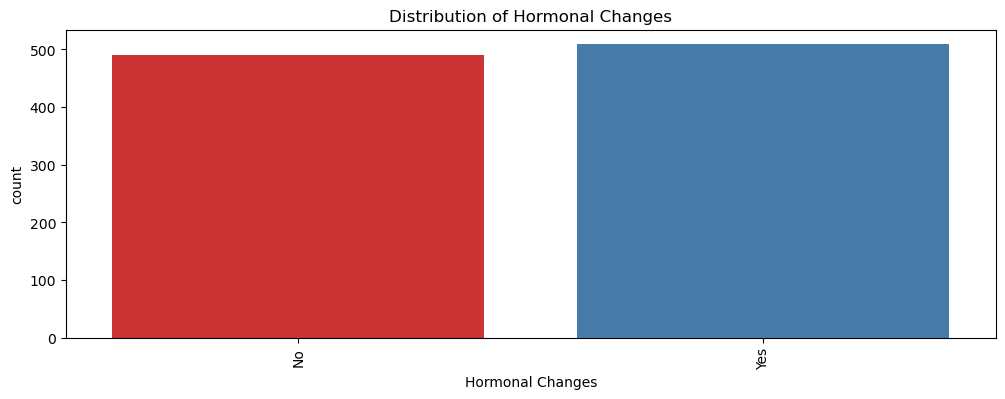

Value counts for Medical Conditions:
 Medical Conditions
No Data                  110
Alopecia Areata          107
Psoriasis                100
Thyroid Problems          99
Androgenetic Alopecia     98
Dermatitis                92
Dermatosis                88
Seborrheic Dermatitis     88
Scalp Infection           79
Eczema                    69
Ringworm                  69
Name: count, dtype: int64


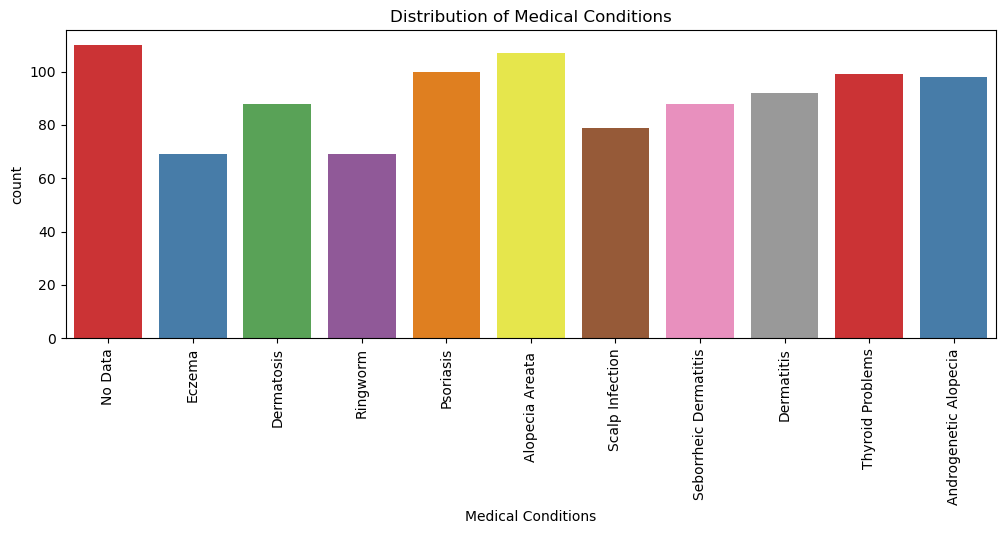

Value counts for Medications & Treatments:
 Medications & Treatments
Rogaine                      116
Antidepressants              110
Steroids                     107
Heart Medication             104
Accutane                     102
Antibiotics                   94
Antifungal Cream              94
Chemotherapy                  90
Blood Pressure Medication     90
Immunomodulators              90
No Data                        2
Name: count, dtype: int64


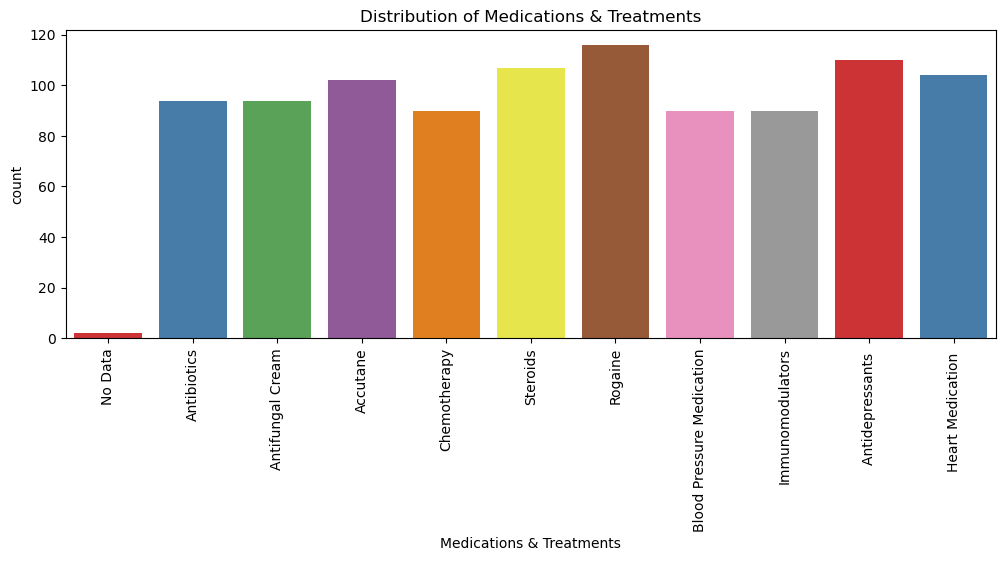

Value counts for Nutritional Deficiencies:
 Nutritional Deficiencies
Zinc Deficiency         108
Vitamin D Deficiency    104
Biotin Deficiency        99
Vitamin A Deficiency     99
Omega-3 fatty acids      92
Protein deficiency       90
Magnesium deficiency     84
Vitamin E deficiency     83
Selenium deficiency      82
No Data                  80
Iron deficiency          78
Name: count, dtype: int64


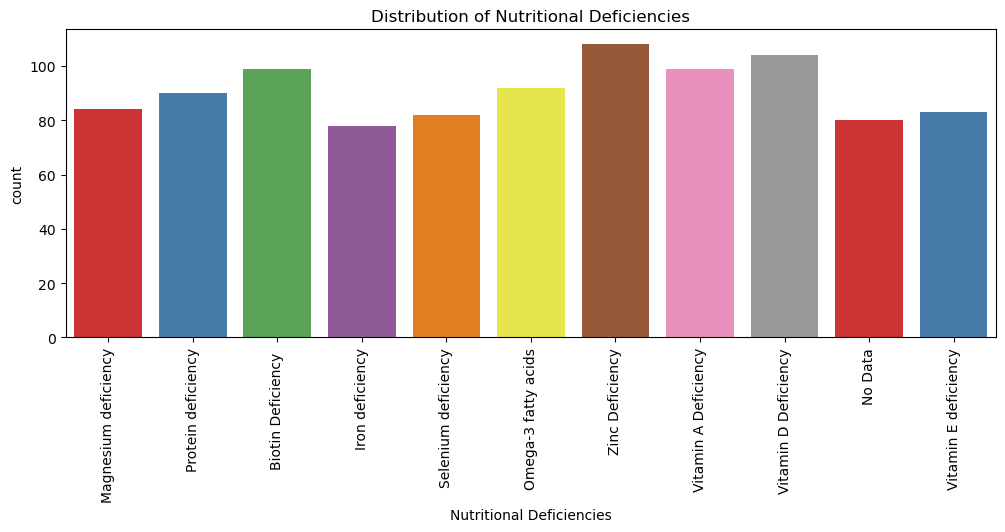

Value counts for Stress:
 Stress
Moderate    351
Low         327
High        321
Name: count, dtype: int64


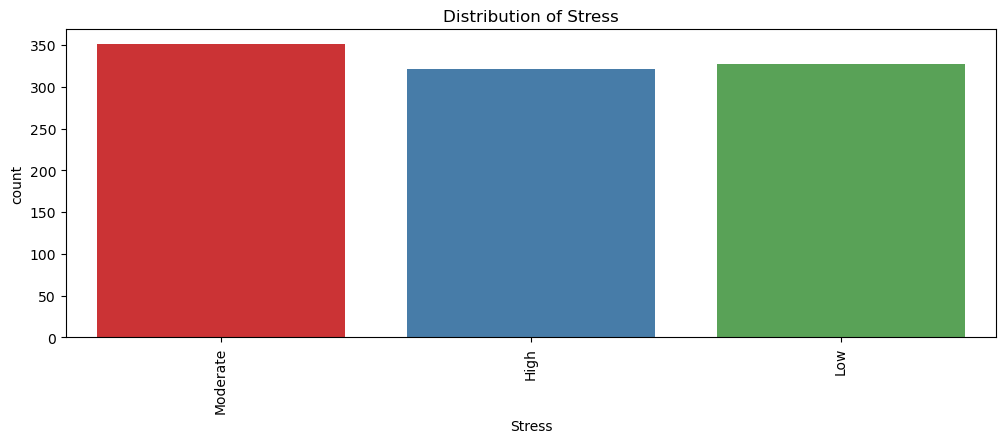

Value counts for Poor Hair Care Habits:
 Poor Hair Care Habits
No     507
Yes    492
Name: count, dtype: int64


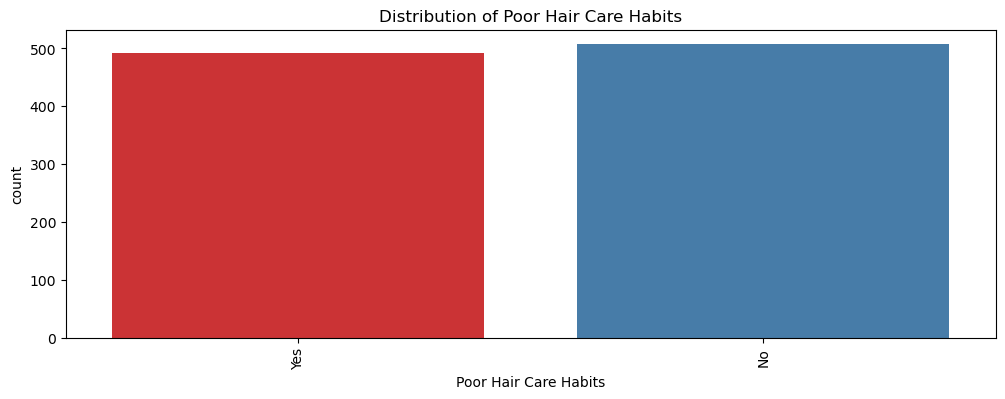

Value counts for Environmental Factors:
 Environmental Factors
Yes    508
No     491
Name: count, dtype: int64


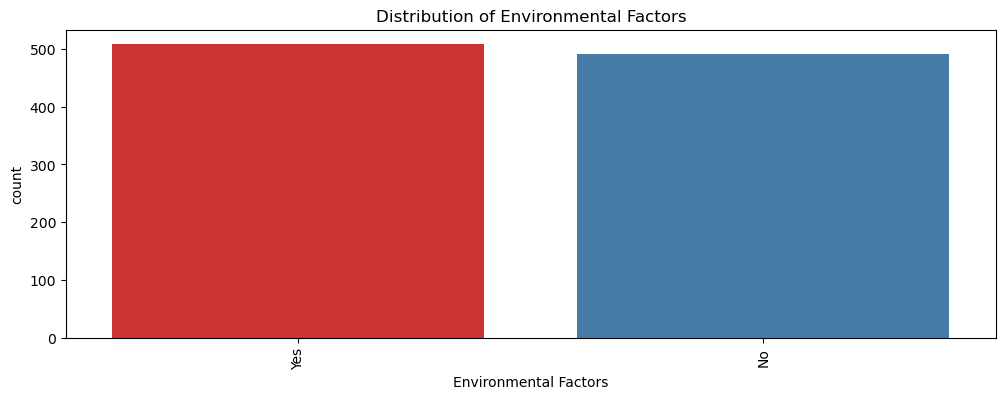

Value counts for Smoking:
 Smoking
Yes    519
No     480
Name: count, dtype: int64


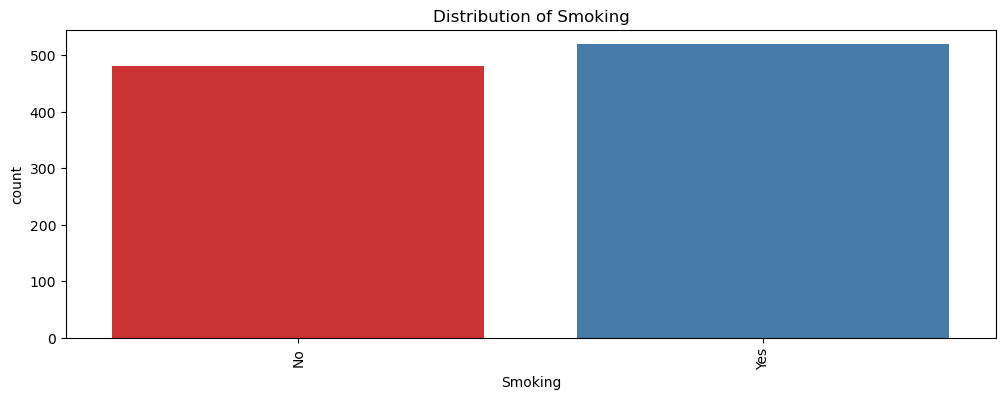

Value counts for Weight Loss:
 Weight Loss
No     527
Yes    472
Name: count, dtype: int64


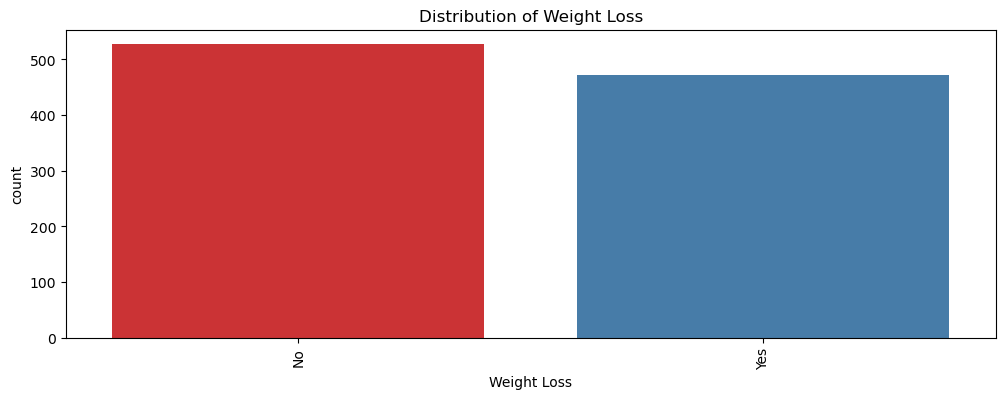

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

categorical_columns = [
    'Genetics', 'Hormonal Changes', 'Medical Conditions', 
    'Medications & Treatments', 'Nutritional Deficiencies', 
    'Stress', 'Poor Hair Care Habits', 
    'Environmental Factors', 'Smoking', 'Weight Loss'
]

for col in categorical_columns:
    print(f"Value counts for {col}:\n", df[col].value_counts())
    
    plt.figure(figsize=(12, 4))
    sns.countplot(x=col, data=df, palette='Set1')
    
    # Rotate x-axis labels by 90 degrees
    plt.xticks(rotation=90)

    plt.title(f'Distribution of {col}')
    plt.show()


Summary Statistics for Age:
count    999.000000
mean      34.188188
std        9.377980
min       18.000000
25%       26.000000
50%       34.000000
75%       42.000000
max       50.000000
Name: Age, dtype: float64


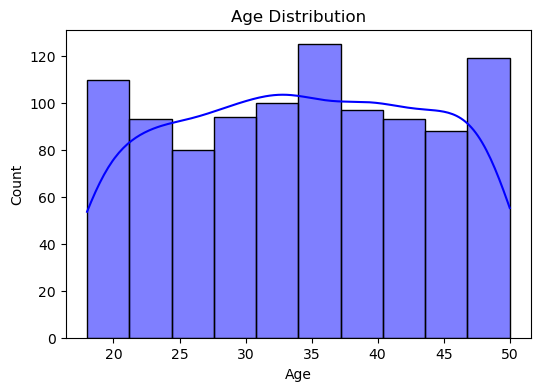

In [67]:
# 4. Descriptive Statistics for Continuous Variables
print("Summary Statistics for Age:")
print(df['Age'].describe())

# Visualize age distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], kde=True, color='blue', bins=10)
plt.title('Age Distribution')
plt.show()


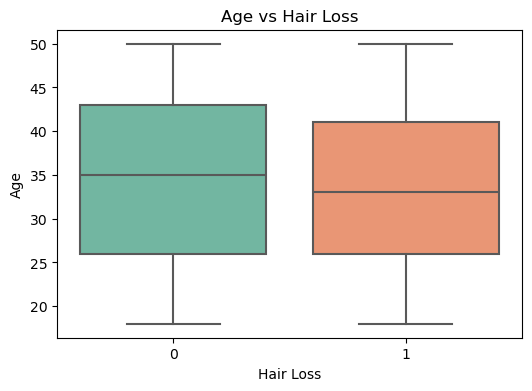

In [68]:
# Continuous Variable (Age) vs Hair Loss
plt.figure(figsize=(6, 4))
sns.boxplot(x='Hair Loss', y='Age', data=df, palette='Set2')
plt.title('Age vs Hair Loss')
plt.show()


In [69]:
from scipy.stats import chi2_contingency

def chi_square_test(feature):
    contingency_table = pd.crosstab(df[feature], df['Hair Loss'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying chi-square test to selected categorical features
categorical_features = ['Genetics', 'Hormonal Changes', 'Poor Hair Care Habits', 
                        'Environmental Factors', 'Smoking', 'Weight Loss','Medical Conditions','Medications & Treatments',
                        'Nutritional Deficiencies','Stress']

print("\nChi-Square Test Results:")
for feature in categorical_features:
    p_value = chi_square_test(feature)
    significance = 'significant' if p_value < 0.05 else 'not significant'
    print(f"{feature}: p-value = {p_value:.4f} ({significance})")


Chi-Square Test Results:
Genetics: p-value = 0.2141 (not significant)
Hormonal Changes: p-value = 0.8719 (not significant)
Poor Hair Care Habits: p-value = 0.2407 (not significant)
Environmental Factors: p-value = 0.5925 (not significant)
Smoking: p-value = 0.0827 (not significant)
Weight Loss: p-value = 0.1758 (not significant)
Medical Conditions: p-value = 0.4571 (not significant)
Medications & Treatments: p-value = 0.9604 (not significant)
Nutritional Deficiencies: p-value = 0.9697 (not significant)
Stress: p-value = 0.6199 (not significant)


In [70]:
# 8. Feature Importance (using Mutual Information)
from sklearn.feature_selection import mutual_info_classif

# Convert categorical variables to numerical using get_dummies (for simplicity)
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

# Perform Mutual Information for Categorical Variables
X = df_encoded  # Feature variables
y = df['Hair Loss']  # Target variable
mi_scores = mutual_info_classif(X, y)

                                              Feature  Mutual Information
3                       Medical Conditions_Dermatitis            0.042407
31           Nutritional Deficiencies_Zinc Deficiency            0.038629
28      Nutritional Deficiencies_Vitamin A Deficiency            0.029574
7                        Medical Conditions_Psoriasis            0.026598
18          Medications & Treatments_Immunomodulators            0.025345
21                  Medications & Treatments_Steroids            0.019985
19                   Medications & Treatments_No Data            0.010752
24                   Nutritional Deficiencies_No Data            0.009630
14          Medications & Treatments_Antifungal Cream            0.007940
34                          Poor Hair Care Habits_Yes            0.006607
8                         Medical Conditions_Ringworm            0.006523
36                                        Smoking_Yes            0.005962
23      Nutritional Deficiencies_Magne

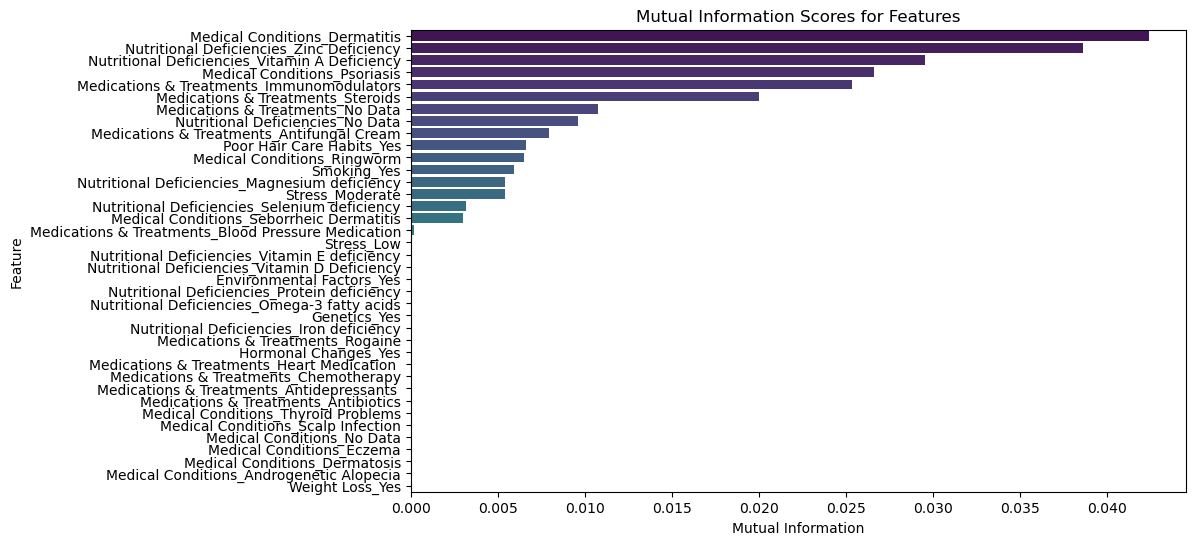

In [71]:
# Display the mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

# Plot Mutual Information scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='viridis')
plt.title('Mutual Information Scores for Features')
plt.show()

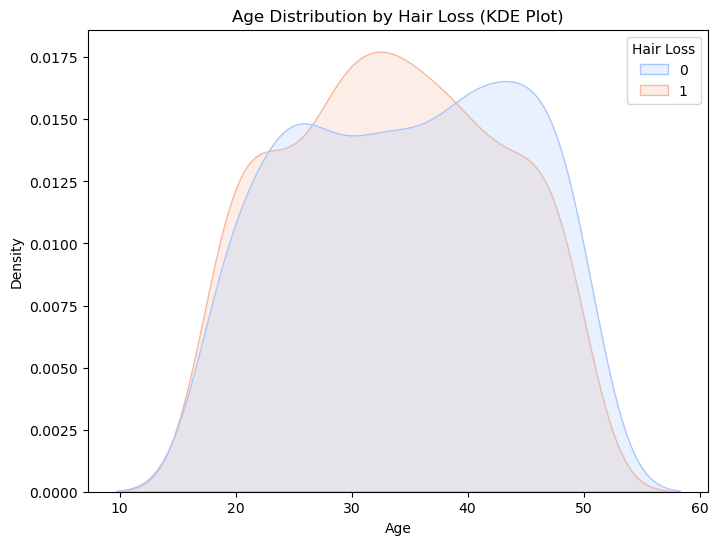

In [72]:
# 4. Distribution of Numerical Features
# KDE plot for age distribution by Hair Loss
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='Age', hue='Hair Loss', fill=True, palette='coolwarm')
plt.title('Age Distribution by Hair Loss (KDE Plot)')
plt.show()

In [73]:
# Categorical variable distribution
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())

Genetics
Yes    522
No     477
Name: count, dtype: int64
Hormonal Changes
Yes    509
No     490
Name: count, dtype: int64
Medical Conditions
No Data                  110
Alopecia Areata          107
Psoriasis                100
Thyroid Problems          99
Androgenetic Alopecia     98
Dermatitis                92
Dermatosis                88
Seborrheic Dermatitis     88
Scalp Infection           79
Eczema                    69
Ringworm                  69
Name: count, dtype: int64
Medications & Treatments
Rogaine                      116
Antidepressants              110
Steroids                     107
Heart Medication             104
Accutane                     102
Antibiotics                   94
Antifungal Cream              94
Chemotherapy                  90
Blood Pressure Medication     90
Immunomodulators              90
No Data                        2
Name: count, dtype: int64
Nutritional Deficiencies
Zinc Deficiency         108
Vitamin D Deficiency    104
Biotin Deficiency  

In [74]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

# List of categorical columns to encode
categorical_columns = [
    'Genetics', 'Hormonal Changes', 'Medical Conditions', 
    'Medications & Treatments', 'Nutritional Deficiencies', 
    'Stress', 'Poor Hair Care Habits', 
    'Environmental Factors', 'Smoking', 'Weight Loss'
]

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Store the encoder for future use if needed

# Check the resulting DataFrame
df.head()


,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss,numerical_outlier,categorical_outlier
0,133992,1,0,5,8,2,2,19,1,1,0,0,0,False,True
1,148393,0,0,4,1,2,0,43,1,1,0,0,0,False,False
2,155074,0,0,3,3,5,2,26,1,1,0,1,0,False,False
3,118261,1,1,7,1,0,2,46,1,1,0,0,0,False,False
4,111915,0,0,6,0,1,2,30,0,1,1,0,1,False,False


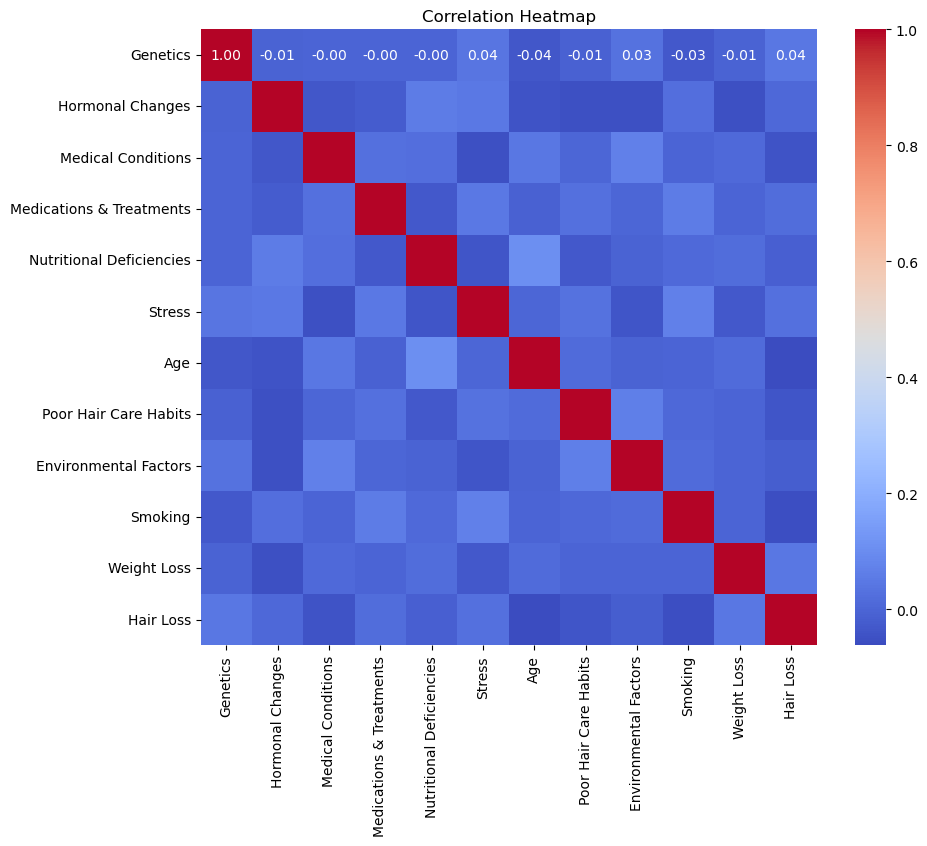

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df.drop(['Id','numerical_outlier', 'categorical_outlier'], axis=1, inplace=True)

# Create a correlation matrix
correlation_matrix = df.corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()
